In [1]:
import polars as pl
import json
from pathlib import Path
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

In [2]:
def process_one_region(region):
    file_path = f'data/{region}.json'

    with open(file_path, 'r') as file:
        # Read in json data (one file for each region)
        data = json.load(file)
         
        # Convert json data to a list of dicts (to facilitate to conversion to a dataframe)
        records = [
            {
                'year': year,
                'named_storms': values[0],
                'named_storm_days': values[1],
                'hurricanes': values[2],
                'hurricane_days': values[3],
                'major_hurricanes': values[4],
                'major_hurricane_days': values[5],
                'ace': values[6],
            }
            for year, values in data.items()
        ]

        # Make a dataframe from the list-o-dicts
        df = (
            pl.DataFrame(records)
            .with_columns(
                # pl.lit(region).cast(pl.Categorical).alias('region'),
                pl.lit(region).alias('region'),
                pl.col('year').cast(pl.UInt16),
            )
        )

        # Put 'region" column first and scoot the rest to the right
        cols = df.columns
        cols = cols[-1:] + cols[:-1]

    return df[cols]

In [3]:
# Grab data from source .json files
data_dir = Path('data')
json_files = [file for file in data_dir.glob('*.json') if file.is_file()]

In [4]:
# Combine all region's pertinent data into one dataframe
master_df = pl.DataFrame()

for file in json_files:
    region = file.stem
    print(f'Processing the {region} region...')
    master_df = master_df.vstack(process_one_region(region))

# Grab only the data needed for the chart
chart_df = (
    master_df
    .filter(
        pl.col('year').is_between(1980, 2023),
        ~pl.col('region').is_in(['global', 'northernhemisphere', 'southernhemisphere'])
    )
    .select(['region', 'year', 'major_hurricanes'])
)

Processing the northeastpacific region...
Processing the southindian region...
Processing the northatlantic region...
Processing the southernhemisphere region...
Processing the southpacific region...
Processing the northindian region...
Processing the global region...
Processing the northernhemisphere region...
Processing the northwestpacific region...


In [5]:
region_labels = {
    'northwestpacific': 'Northwest Pacific',
    'northeastpacific': 'Northeast Pacific',
    'northatlantic': 'North Atlantic',
    'southindian': 'South Indian',
    'southpacific': 'South Pacific',
    'northindian': 'North Indian',
}

In [6]:
# from bottom to top, how Chris stacked his bars
region_sort_order = [
    'northwestpacific',
    'northeastpacific',
    'northatlantic',
    'southindian',
    'southpacific',
    'northindian',
]

In [7]:
# Discovered from Mac's builtin Digital Color Meter app which has a color picker
region_colors = {
    'northwestpacific': '#15027d',
    'northeastpacific': '#4677a3',
    'northatlantic': '#34aa9f',
    'southindian': '#54dacb',
    'southpacific': '#648412',
    'northindian': '#cc9c09',
}

### `altair` chart

In [7]:
region_color_map = alt.Scale(
    domain=list(region_colors.keys()),
    range=list(region_colors.values())
)

In [ ]:
# Make the chart
alt.Chart(df).mark_bar().encode(
    x=alt.X(
        'year',
        title='Year',
        scale=alt.Scale(domain=[1980, 2023])
    ),
    y='major_hurricanes',
    color=alt.Color(
        'region',
        title='Region',
        # sort=region_order,
        scale=region_color_map
    ),
    tooltip=['year', 'region', 'major_hurricanes']
)

#### ISSUE
The `sort` parameter of the `color` encoding is not being honored.

Not matter what the sort order is specified as, the bars will always be stacked in alphabetical order!

Is it time to ditch altair?

### `matplotlib` chart

In [8]:
wide = chart_df.pivot(on='year', values='major_hurricanes')

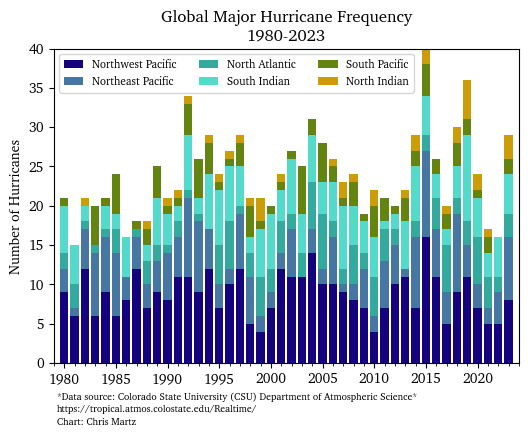

In [18]:
# years as a tuple (or a list, whatevs) 
years = chart_df['year'].unique().to_list()

# region_hurricanes as dict {region: list of major_hurricane values}
region_hurricanes = {row[0]: list(row[1:]) for row in wide.rows()}

# calculate # of years in the dataset (that's how many bar stacks there are)
n_years = len(years)

# initialize stack_bottom to np.zeros(n_years)
stack_bottom = np.zeros(n_years)

width = 0.8
fig, ax = plt.subplots(figsize=(6, 4.25))

plt.subplots_adjust(bottom=0.14)  # won't add this space if nothing uses that space

# Build the stack
for region in region_sort_order:
    p = ax.bar(
        years,
        region_hurricanes[region],
        width=width,
        label=region,
        bottom=stack_bottom,
        color=region_colors[region]
    )
    stack_bottom += region_hurricanes[region]

# Set the axes' view scope
ax.set_xlim(1979, 2024)
ax.set_ylim(0, 40)

# Set the major and minor tick frequency
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

# Customize the plot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Charter', 'Didot']
plt.ylabel('Number of Hurricanes')
plt.title('Global Major Hurricane Frequency\n1980-2023')

# Add a footer
footer_text_1 = '*Data source: Colorado State University (CSU) Department of Atmospheric Science*'
footer_text_2 = 'https://tropical.atmos.colostate.edu/Realtime/' 
footer_text_3 = 'Chart: Chris Martz'

fig.text(.13, 0.06, footer_text_1, ha='left', va='center', fontsize=7)
fig.text(.13, 0.03, footer_text_2, ha='left', va='center', fontsize=7)
fig.text(.13, 0, footer_text_3, ha='left', va='center', fontsize=7)

# Set the legend
legend = ax.legend(
    ncol=3,
    loc='upper left',
    bbox_to_anchor=(0, 1),
    fontsize=8,
    handlelength=1.75
)

# Rewrite the legend labels to human-ify the region
region_labels_list = list(region_labels.values())
for text, label in zip(legend.get_texts(), region_labels_list):
    text.set_text(label)

plt.show()
    

In [ ]:
(
    chart_df
    .filter(pl.col('year') == 1980)
)

### TODO
* add attribution footers

### Concerns

#### Concern: totals do not match
There are too many "close but not quite" values.

Could be due to source data files changing.  (Data from the web site is just a snapshot.)

#### Concern: consistent stack order
Chris' stack order is not consistent year after year.

When it exists, North Indian should be the top-most stack piece.

Yet 1990, 1992, 2006, 2013, and 2014 all show North Indian be the second top-most stack piece.


#### Concern: multiple stack pieces in the same year

eg, 1990 has two South Indian stack pieces.  So does 1992.

This raises concern about the aggregation of data.
